```python
                       Project:  'Serpro - Bootcamp Apex'
 Authors:          
        'Strauss'
        'Danilo Freitas'
        'Renato Monteiro'
 Advisor:
        'Marcelo Pita'        
 Date: '02/12/2020 19:51:02'        
```

In [175]:
#bibliotecas padrão
import pandas as pd
import numpy as np
import time
import itertools #iteração/gráficos
import re #expressao regular
import string
import pickle

#conexão datalake
from datalake_serpro import handler_dl 
import datalake_serpro

#pacotes a parte do pandas/impala
from pandas.api.types import is_numeric_dtype
from pandas.api.types import is_string_dtype
from impala.util import as_pandas 

#bibliotecas de visualização/gráficos
import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib

#Libs para processamento de linguagem natural (NLP). Usamos para limpeza (spacy) e stop words (nltk) (libs muito grandes)
import nltk
import spacy
from nltk.corpus import stopwords #para remover palavras irrelevantes, fornece uma lista em português
#from nltk.tokenize import sent_tokenize #para analise de sentimento
from nltk.tokenize import RegexpTokenizer #quebra frases em palavras
from unicodedata import normalize

#Vetorização de texto
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#LDA e NMF - Importa os algoritmos de modelagem de tópicos
from sklearn.decomposition import LatentDirichletAllocation, NMF

from sklearn.feature_selection import chi2

import pyLDAvis
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
#import itables.interactive
from IPython.core.display import HTML

#Diminui o log de execução
import warnings
warnings.filterwarnings('ignore')

#### 0) Configs

In [176]:
conn = handler_dl()
cursor = conn.cursor()
db = 'cnpj_rfb'
tb = 'apex_news' 
text = 'noticia_texto'
tkn = RegexpTokenizer(r'\w+') #
textos_tokenizados = []
random_state = 1214
pth = '/home/07971910703/dataset/'

#### 1) Functions

In [107]:
def imprimir_top_palavras(modelo_topico, palavras, topn): #passa o modelo treinado
    probabilidades =\
        modelo_topico.components_ / modelo_topico.components_.sum(axis=1)[:, np.newaxis]
    for topico_idx, topico in enumerate(probabilidades):
        top_palavras_idx = topico.argsort()[:-topn - 1:-1]
        print("Tópico %d:" % topico_idx)
        for i in top_palavras_idx:
            print("        " + palavras[i] + "   " +\
                  str(round(topico[i], 6)))
    print()

In [108]:
def get_word_topics(model, words_set, topn):
    topics = []
    words  = []
    scores = []
    prob = model.components_ / model.components_.sum(axis=1)[:, np.newaxis]
    for topic_idx, topic in enumerate(prob):
        top_words_idx = topic.argsort()[:-topn - 1:-1]
        for i in top_words_idx:
            topics.append(topic_idx)
            words.append(words_set[i])
            scores.append(round(topic[i], 6))
              
    df = pd.DataFrame({'topico':topics, 'palavra':words, 'score': scores})
    return df

In [109]:
def clear_text(text):    
    text = text.lower()
    text = normalize('NFKD', text).encode('ASCII', 'ignore').decode('ASCII')
    text = re.sub(r'[^a-zA-Z_]',' ',text)
    tokens = tkn.tokenize(text)
    tokens = [palavra for palavra in tokens if len(palavra) >= 3]      
    text = ' '.join(tokens)      
    return text

In [110]:
def lemma_text(text):
    sent = ''
    doc  = nlp(text)    
    for token in doc:
        sent = sent + ' ' + str(token.lemma_)
        #print(token.lemma_)
    return sent

In [111]:
def compute_text_size(text):
    return len(text) 

In [112]:
def get_topic_name(topic):
    topics = {0:'Government', 
              1:'Aerospace', 
              2:'Health', 
              3:'Agribusiness', 
              4:'Economy', 
              5:'Military'}
              #6:'Infrastructured'}
    return topics.get(topic)

In [113]:
def sampling_n(group, k=1000):
    if len(group) < k:
        return group
    return group.sample(k)

#### 2) Load libraries

In [114]:
nlp = spacy.load('pt_core_news_sm')

#### 3) Data Access

In [177]:
sql = ('select * from {0}.{1}'.format(db,tb))
cursor.execute(sql)
dfrw = as_pandas(cursor)
dfrw.tail(6)

,noticia_texto,fonte
22820,"Brasília, 24 de dezembro de 2018 – A participa...",anac
22821,Moreira Franco nega que autoridades imporão “t...,infraestrutura
22822,A Agência Nacional de Vigilância Sanitária (An...,anvisa
22823,Brasília (DF) – A Agência Nacional de Aviação ...,infraestrutura
22824,A Anvisa atualizou a lista das Denominações Co...,anvisa
22825,"O Conselho Monetário Nacional editou, em 02 de...",agricultura


In [ ]:
#dfrw = pd.read_csv(pth + 'drw_appex_news.csv', sep = ',')

In [ ]:
#dfrw = dfrw.sample(frac=0.5,random_state=random_state)

In [117]:
dfsp = dfrw.groupby('fonte').apply(sampling_n).reset_index(drop=True)

In [118]:
dfsp.fonte.value_counts()

planalto          1000
defesa            1000
mre               1000
economia          1000
infraestrutura    1000
anvisa            1000
anac              1000
agricultura       1000
financas           754
Name: fonte, dtype: int64

In [119]:
dfrw = dfsp

In [120]:
text_raw = []
for texto in dfrw['noticia_texto'].to_list():
    text_raw.append(texto)
len(text_raw)

8754

In [121]:
text_raw[0]

'A ministra Tereza Cristina (Agricultura, Pecuária e Abastecimento) falou nesta terça-feira (19) sobre boas práticas de agricultura sustentável em palestra no Instituto Brasil do Wilson Center (centro internacional de estudos e pesquisas).No evento, a ministra destacou\xa0que vem crescendo no mundo a demanda por alimentos que sejam produzidos com impacto ambiental mínimo e baixo custo. E o\xa0Tereza Cristina citou que, nos últimos 40 anos, a área ocupada pela agricultura no Brasil aumentou 33%, enquanto a produção cresceu em torno de 386%. Segundo a ministra, este incremento de produtividade é resultado de décadas de investimento em pesquisa e desenvolvimento e de boas políticas públicas.“O Brasil conta com uma das legislações ambientais mais exigentes do mundo. Nosso Código Florestal exige que os produtores rurais destinem uma parte da sua propriedade para preservação. Dito de outra forma, eles não podem produzir nesta área. Na Amazônia, por exemplo, 80% da área de uma propriedade é d

#### 4) Text Treatment

In [122]:
dfrw.dropna(inplace=True)

In [123]:
dfrw[text] = dfrw[text].apply(clear_text)

In [124]:
dfrw[text] = dfrw[text].apply(lemma_text)

In [125]:
dfrw['tamanho'] = dfrw[text].apply(compute_text_size)

In [126]:
textos_tokenizados = []
for texto in dfrw[text].to_list():
    textos_tokenizados.append(nlp(texto))
len(textos_tokenizados)

8754

In [127]:
sources = []
for source in dfrw['fonte'].to_list():
    sources.append(source)
len(sources)

8754

In [128]:
texts_size = []
for text in dfrw['tamanho'].to_list():
    texts_size.append(text)
len(texts_size)

8754

In [129]:
textos_partes_fala = []
for tt in textos_tokenizados:
    textos_partes_fala.append([(p.text, p.pos_)for p in tt])
len(textos_partes_fala)

8754

In [130]:
# Filtragem de partes da fala de interesse:
sintax = ['NOUN', 'PROPN', 'ADJ', 'VERB']
sintax = ['NOUN','PROPN','PRON']          
#sintax = ['NOUN', 'ADJ']  
#sintax = ['NOUN']  

noticias_filtradas = []
for t in textos_partes_fala:
    texto_filtrado = []
    for palavra, parte_fala in t:
        if parte_fala in sintax:
            texto_filtrado.append(palavra)
    noticias_filtradas.append(" ".join(texto_filtrado).lower())   
len(noticias_filtradas)

8754

In [131]:
dfcl = pd.DataFrame({'noticia_texto':noticias_filtradas, 'fonte':sources, 'tamanho': texts_size})

In [132]:
dfcl.to_csv(pth + 'dcl_appex_news_001.csv', index=False)

In [133]:
#dfcl = pd.read_csv(pth + 'dcl_appex_news_001.csv', sep = ',')

In [134]:
dfcl['tokens'] = dfcl['noticia_texto'].apply(tkn.tokenize)
n_token = [word for tokens in dfcl["tokens"] for word in tokens]
n_setence = [len(tokens) for tokens in dfcl["tokens"]]
vocab = sorted(list(set(n_token)))
print('Vocabulario:{0}'.format(len(vocab)))
print('Registros:{0}'.format(len(n_setence)))
print('Tokens:{0}'.format(len(n_token)))

Vocabulario:31919
Registros:8754
Tokens:814780


<AxesSubplot:xlabel='Tamanho da setença', ylabel='Número de sentenças'>

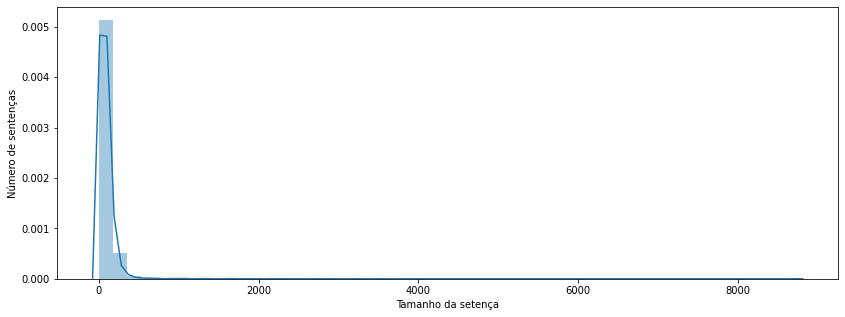

In [135]:
fig = plt.figure(figsize=(14, 5)) 
plt.xlabel('Tamanho da setença')
plt.ylabel('Número de sentenças')
sb.distplot(n_setence)

#### 5) Feature Selection

In [136]:
#vec_cnt = CountVectorizer(max_df=0.5, min_df=3)
#features_vec_cnt = vec_cnt.fit_transform(dfcl[text])
#features_vec_cnt.shape

In [137]:
vec_tfid01 = TfidfVectorizer(sublinear_tf=True, 
                            norm='l2', 
                            encoding='latin-1', 
                            ngram_range=(1,1), #vai pegar uma palavra (unigrama)                       
                            stop_words=stopwords.words('portuguese'),
                            tokenizer=tkn.tokenize)
features_tfid01 = vec_tfid01.fit_transform(dfcl['noticia_texto'])
chi2_score = chi2(features_tfid01, dfcl['fonte'])[0]

In [138]:
zipped = zip(vec_tfid01.get_feature_names(), chi2_score, dfcl['fonte'])
#zipped = sorted(zipped, key = lambda x: x[1])
#top_words = zip(zipped[-10:])
df_chi2 = pd.DataFrame(list(zipped), columns = ['palavra', 'chi2','fonte']) 
df_chi2.sort_values(by=['chi2'], inplace=True, ascending=False)
df_chi2.head(10)

,palavra,chi2,fonte
1607,anac,885.142322,anac
1915,anvisa,843.977712,anac
961,agricultura,658.229716,agricultura
4017,bolsonaro,478.414153,economia
3000,aviacao,436.118761,defesa
39,abastecimento,323.857321,agricultura
747,aeroporto,241.522566,agricultura
8514,defeso,236.051755,planalto
697,aereo,206.398348,agricultura
696,aereas,187.351608,agricultura


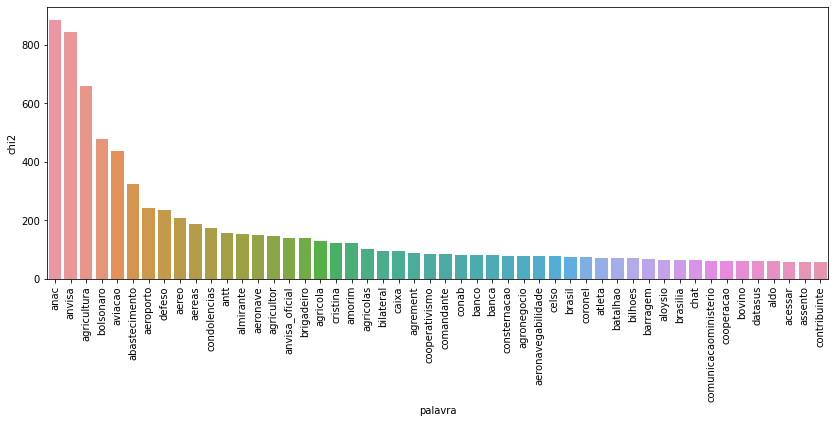

In [139]:
fig = plt.figure(figsize=(14, 5)) 
sb.barplot(x = 'palavra', y = 'chi2', data = df_chi2.head(50))
plt.xticks(rotation=90)
plt.show()

In [140]:
df_chi2 = df_chi2[(df_chi2.chi2 >= 2.8)] 
len(df_chi2)

2241

#### 6) Vectorization 

#### 6.1) Counter Vectorizer

In [141]:
vec_cnt = CountVectorizer(max_df=0.5, min_df=3)
features_vec_cnt = vec_cnt.fit_transform(dfcl['noticia_texto'])
features_vec_cnt.shape

(8754, 11716)

#### 6.2) TFID-Vectorizer

In [142]:
vec_tfid02 = TfidfVectorizer(vocabulary=df_chi2['palavra'],
                        sublinear_tf=True, 
                        #min_df=1, 
                        #max_df=0.85, 
                        #max_features=2000, 
                        norm='l2', 
                        encoding='latin-1', 
                        ngram_range=(1,1),                        
                        stop_words=stopwords.words('portuguese'),
                        tokenizer=tkn.tokenize)
features_tfid02 = vec_tfid02.fit_transform(dfcl['noticia_texto'])
features_tfid02.shape

(8754, 2241)

#### 7) Topic modeling - técnicas de aprendizado de máquina estatístico para classificação, agrupamento, e detecção de outliers.

##### 7.1) NMF 

In [143]:
K = 6
nmf = NMF(n_components=K, init='nndsvd', max_iter=1000)
start = time.perf_counter()
nmf.fit(features_tfid02)
end = time.perf_counter() 
timeit = end - start
print(timeit)

0.37889232486486435


In [144]:
nmf

NMF(alpha=0.0, beta_loss='frobenius', init='nndsvd', l1_ratio=0.0,
  max_iter=1000, n_components=6, random_state=None, shuffle=False,
  solver='cd', tol=0.0001, verbose=0)

In [145]:
 nmf.components_.shape

(6, 2241)

#### Results

In [146]:
df_result = get_word_topics(nmf, vec_tfid02.get_feature_names(), 20) 
df_result['topico'] = df_result['topico'].apply(get_topic_name)

In [168]:
df = df_result[(df_result['topico'] == get_topic_name(0))]
df.head(20)

,topico,palavra,score
0,Government,brasil,0.033768
1,Government,defeso,0.025402
2,Government,cooperacao,0.015635
3,Government,brasileiro,0.015207
4,Government,acoes,0.014286
5,Government,comer,0.012330
6,Government,atividades,0.009637
7,Government,brasilia,0.009478
8,Government,chefe,0.009470
9,Government,areas,0.008943


In [148]:
df = df_result[(df_result['topico'] == get_topic_name(1))]
df.head(20)

,topico,palavra,score
20,Aerospace,anac,0.093114
21,Aerospace,aviacao,0.072567
22,Aerospace,aeroporto,0.048920
23,Aerospace,aeronave,0.028447
24,Aerospace,brasilia,0.026668
25,Aerospace,aereas,0.024554
26,Aerospace,aereo,0.023539
27,Aerospace,companhia,0.014032
28,Aerospace,audiencia,0.012040
29,Aerospace,contribuicoes,0.011886


In [166]:
df = df_result[(df_result['topico'] == get_topic_name(2))]
df.head(40)

,topico,palavra,score
40,Health,anvisa,0.194921
41,Health,anvisa_oficial,0.020803
42,Health,contribuicoes,0.017972
43,Health,avaliacao,0.017262
44,Health,controlo,0.014573
45,Health,alimento,0.013651
46,Health,autorizacao,0.012686
47,Health,atendimento,0.011849
48,Health,basto,0.011300
49,Health,comercializacao,0.011271


In [150]:
df = df_result[(df_result['topico'] == get_topic_name(3))]
df.head(20)

,topico,palavra,score
60,Agribusiness,agricultura,0.112970
61,Agribusiness,abastecimento,0.056325
62,Agribusiness,agricultor,0.021381
63,Agribusiness,agricola,0.021134
64,Agribusiness,cristina,0.019044
65,Agribusiness,alimento,0.016211
66,Agribusiness,agricolas,0.014890
67,Agribusiness,cultura,0.013499
68,Agribusiness,agronegocio,0.012116
69,Agribusiness,alimentacao,0.010166


In [151]:
df = df_result[(df_result['topico'] == get_topic_name(4))]
df.head(20)

,topico,palavra,score
80,Economy,bilhoes,0.049517
81,Economy,ano,0.044330
82,Economy,banco,0.024218
83,Economy,crescimento,0.021052
84,Economy,atendimento,0.012492
85,Economy,covid,0.012036
86,Economy,central,0.011662
87,Economy,bilhao,0.011203
88,Economy,acesso,0.011202
89,Economy,caixa,0.011089


In [152]:
df = df_result[(df_result['topico'] == get_topic_name(5))]
df.head(20)

,topico,palavra,score
100,Military,bolsonaro,0.197051
101,Military,brasil,0.064948
102,Military,compromisso,0.016399
103,Military,congresso,0.016193
104,Military,abertura,0.015627
105,Military,brasileiro,0.013775
106,Military,certeza,0.012321
107,Military,confianca,0.011942
108,Military,chino,0.011279
109,Military,coisa,0.010638


In [169]:
df = df_result[(df_result['topico'] == get_topic_name(6))]
df.head(20)

,topico,palavra,score


In [154]:
df_result.to_csv(pth + 'df_topicos_004.csv', index=False, sep=';')

In [155]:
t0 = []
t1 = []
t2 = []
t3 = []
t4 = []
t5 = []
t6 = []

for idx, row in dfcl.iterrows():
    texts = []
    texts.append(row.noticia_texto)
    texts_vec = vec_tfid02.transform(texts)
    topics = nmf.transform(texts_vec)
    t0.append(topics[0][0])
    t1.append(topics[0][1])
    t2.append(topics[0][2])
    t3.append(topics[0][3])
    t4.append(topics[0][4])
    t5.append(topics[0][5])
    #t6.append(topics[0][6])
    
df_result_full = pd.DataFrame({'fonte': list(dfcl.fonte),
                               'noticia_texto_original': text_raw,
                               'score_t0': t0, 
                               'score_t1': t1,
                               'score_t2': t2,
                               'score_t3': t3,
                               'score_t4': t4,
                               'score_t5': t5})
                               #'score_t6': t6})

In [156]:
df_result_full.head(10)

,fonte,noticia_texto_original,score_t0,score_t1,score_t2,score_t3,score_t4,score_t5
0,agricultura,"A ministra Tereza Cristina (Agricultura, Pecuá...",0.025729,0.000000,0.000000,0.174348,0.025302,0.022432
1,agricultura,A Secretaria de Aquicultura e Pesca do Ministé...,0.017599,0.000000,0.004493,0.165187,0.004213,0.006992
2,agricultura,Ela ressaltou que o mercado de soja já é conhe...,0.029103,0.000000,0.000000,0.098498,0.016310,0.025386
3,agricultura,O Serviço de Inspeção Estadual (SIE) do Rio de...,0.000000,0.000000,0.000000,0.144873,0.000000,0.000000
4,agricultura,"A partir do dia 1º de outubro, as empresas que...",0.000000,0.002347,0.000000,0.146854,0.000000,0.000000
5,agricultura,"O Ministério da Agricultura, Pecuária e Abaste...",0.021995,0.006551,0.001040,0.098488,0.003381,0.000000
6,agricultura,O Instituto Nacional de Colonização e Reforma ...,0.015508,0.003980,0.004224,0.038590,0.009991,0.024265
7,agricultura,"Ao final do encontro, a ata com os resultados ...",0.000000,0.000000,0.000000,0.000000,0.166477,0.000000
8,agricultura,A Secretaria de Política Agrícola do Ministéri...,0.000000,0.000000,0.003198,0.103857,0.040315,0.003231
9,agricultura,"organizam, de 14 a 18 de setembro, o 2º Encon...",0.050663,0.000000,0.000000,0.079121,0.026227,0.014939


In [157]:
df_result_full['score_sum'] =  df_result_full[['score_t0', 
                                               'score_t1',
                                               'score_t2',
                                               'score_t3',
                                               'score_t4',
                                               'score_t5']].sum(axis=1)

In [158]:
df_result_full['score_t0'] = df_result_full['score_t0'] / df_result_full['score_sum'] 
df_result_full['score_t1'] = df_result_full['score_t1'] / df_result_full['score_sum'] 
df_result_full['score_t2'] = df_result_full['score_t2'] / df_result_full['score_sum'] 
df_result_full['score_t3'] = df_result_full['score_t3'] / df_result_full['score_sum'] 
df_result_full['score_t4'] = df_result_full['score_t4'] / df_result_full['score_sum'] 
df_result_full['score_t5'] = df_result_full['score_t5'] / df_result_full['score_sum'] 

In [159]:
df_result_full.shape

(8754, 9)

In [160]:
df_result_full = df_result_full[(df_result_full.score_sum > 0)]

In [161]:
df_result_full.to_csv(pth + 'df_topicos_noticias_005.csv', index=False, sep=';')

In [162]:
dfs = df_result_full[(df_result_full.score_sum == 0)]
dfs

,fonte,noticia_texto_original,score_t0,score_t1,score_t2,score_t3,score_t4,score_t5,score_sum


In [163]:
df_result_full.shape

(8180, 9)

In [164]:
df_result_full.head(10)

,fonte,noticia_texto_original,score_t0,score_t1,score_t2,score_t3,score_t4,score_t5,score_sum
0,agricultura,"A ministra Tereza Cristina (Agricultura, Pecuá...",0.103825,0.000000,0.000000,0.703550,0.102102,0.090522,0.247811
1,agricultura,A Secretaria de Aquicultura e Pesca do Ministé...,0.088668,0.000000,0.022637,0.832243,0.021227,0.035226,0.198484
2,agricultura,Ela ressaltou que o mercado de soja já é conhe...,0.171904,0.000000,0.000000,0.581805,0.096340,0.149950,0.169297
3,agricultura,O Serviço de Inspeção Estadual (SIE) do Rio de...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.144873
4,agricultura,"A partir do dia 1º de outubro, as empresas que...",0.000000,0.015731,0.000000,0.984269,0.000000,0.000000,0.149201
5,agricultura,"O Ministério da Agricultura, Pecuária e Abaste...",0.167317,0.049833,0.007912,0.749221,0.025716,0.000000,0.131454
6,agricultura,O Instituto Nacional de Colonização e Reforma ...,0.160606,0.041220,0.043746,0.399656,0.103467,0.251303,0.096558
7,agricultura,"Ao final do encontro, a ata com os resultados ...",0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.166477
8,agricultura,A Secretaria de Política Agrícola do Ministéri...,0.000000,0.000000,0.021236,0.689614,0.267692,0.021457,0.150601
9,agricultura,"organizam, de 14 a 18 de setembro, o 2º Encon...",0.296360,0.000000,0.000000,0.462831,0.153420,0.087389,0.170950


#### Save Models

In [165]:
vec_tfid_nm = 'vec_tfid.pkl'
model_nm = 'model_nmf.pkl'

file = open(pth + vec_tfid_nm,'wb')
pickle.dump(vec_tfid02,file)
file.close()

file = open(pth + model_nm,'wb')
pickle.dump(nmf,file)
file.close()